In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time

import jax
import jax.numpy as jnp



In [8]:
lgMh_data = np.load("../../data/3000_12_8/truth_lgMh.npy")

X_0 = np.load("../../data/3000_12_8/data.npy")
covar =  np.load("../../data/3000_12_8/covar.npy")
covar_inv = np.linalg.inv(covar)
X_err = np.load("../../data/3000_12_8/1D_errors.npy")

In [9]:
@jax.jit
def cumulative(lgMs_1D:np.ndarray):

    """_summary_
    Measure the CSMF using the same mass bins!

    Args:
        lgMs_1D (np.ndarray): 1D halo mass array

    Returns:
        np.ndarray: the cumulative counts in each bin
    """

    mass_bins = np.linspace(4,11,45)
    N = jnp.histogram(lgMs_1D, bins=mass_bins)[0]
    Nsub = jnp.sum(N)
    stat = Nsub-np.cumsum(N) 
    return jnp.insert(stat, 0, Nsub) #to add the missing index

def SHMR(lgMh_2D, alpha, delta, sigma):

    """
    Returns: the log stellar mass array with an added dimension corresponding to the random samples
    """

    M_star_a = 10 # these are the anchor points
    M_halo_a = 11.67

    #print("not normalizing for the upscatter and assuming a 2D input array")
    lgMs_2D = alpha*(lgMh_2D-M_halo_a) - delta*(lgMh_2D-M_halo_a)**2 + M_star_a
    scatter = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
    return lgMs_2D + scatter

def find_nearest(values):
    mass_bins = np.linspace(4,11,45)
    indices = np.abs(np.subtract.outer(mass_bins, values)).argmin(0)
    return indices

def MODEL(theta):
    
    alpha, delta, sigma = theta

    lgMs_2D = SHMR(lgMh_data, alpha, delta, sigma) # will be a 3D array if sigma is non zero
    
    counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    mass_ind = find_nearest([6.5, 7, 7.5])

    Ns = [] # counts from the median value
    Ss = [] # scatter from the 95 and 5 percentiles
    for i in mass_ind:
        Ns.append(quant[1, i])
        Ss.append(quant[2, i] - quant[0,i])

    model = Ns + Ss

    return np.array(model)

In [10]:
# chi_dim = 15
# alpha_space = np.linspace(1,3,chi_dim)
# delta_space = np.linspace(-1,3,chi_dim)
# sigma_space = np.linspace(0,3,chi_dim)

# chi_mat = np.zeros(shape=(chi_dim,chi_dim,chi_dim))

# for i, aval in enumerate(alpha_space):
#     for j, dval in enumerate(delta_space):
#         for k, sval in enumerate(sigma_space):
#             theta = [aval,dval,sval]
#             model = MODEL(theta)
#             chi_mat[i,j,k] = np.sum((model - X_0)**2/X_err**2)


# ai, di, si = np.where(chi_mat == np.min(chi_mat))

# theta_0 = [alpha_space[ai][0], delta_space[di][0], sigma_space[si][0]]

theta_0 = [2.4285714285714284, -0.1428571428571429, 0.42857142857142855]

In [15]:

def lnlike_fullcov(theta):
    model = MODEL(theta)
    X = model - X_0
    X_vec = np.expand_dims(X, axis=1)
    covar_inv = np.linalg.inv(covar)
    chisquare = X_vec.transpose().dot(covar_inv).dot(X_vec)
    return -1/2*np.sum(chisquare)


def lnprior(theta):
    alpha, delta, sigma = theta
    if 1.0 < alpha < 3.0 and -1 < delta < 3 and 0 < sigma < 3:
        return 0.0
    return -np.inf


def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_fullcov(theta)    


In [16]:
nwalkers = 100
niter = 100
ndim = 3
p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
burn = 20

In [14]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    start = time.time()
    p0, _, _ = sampler.run_mcmc(p0, burn)
    sampler.reset()
    sampler.run_mcmc(p0, niter)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Multiprocessing took 5.7 seconds


In [17]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    start = time.time()
    p0, _, _ = sampler.run_mcmc(p0, burn)
    sampler.reset()
    sampler.run_mcmc(p0, niter)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Multiprocessing took 141.9 seconds


In [54]:
sampler.get_chain().shape

(12, 1000, 3)

In [44]:
def make_chain_plot(sampler, converge=False):
    samples = sampler.get_chain()
    labels = ['$\\alpha$','$\\delta$','$\\sigma$']
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.1)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()
    
    if converge == True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

def make_corner_plot(sampler):

    labels = ['$\\alpha$','$\\delta$','$\\sigma$']
    samples = sampler.flatchain
    fig = corner.corner(samples, show_titles=True, labels=labels, truths=[1.85, 0.2, 0.3],
                        range=[(1, 3), (-1, 3), (0, 3)], quantiles=[0.16, 0.5, 0.84], plot_datapoints=False)

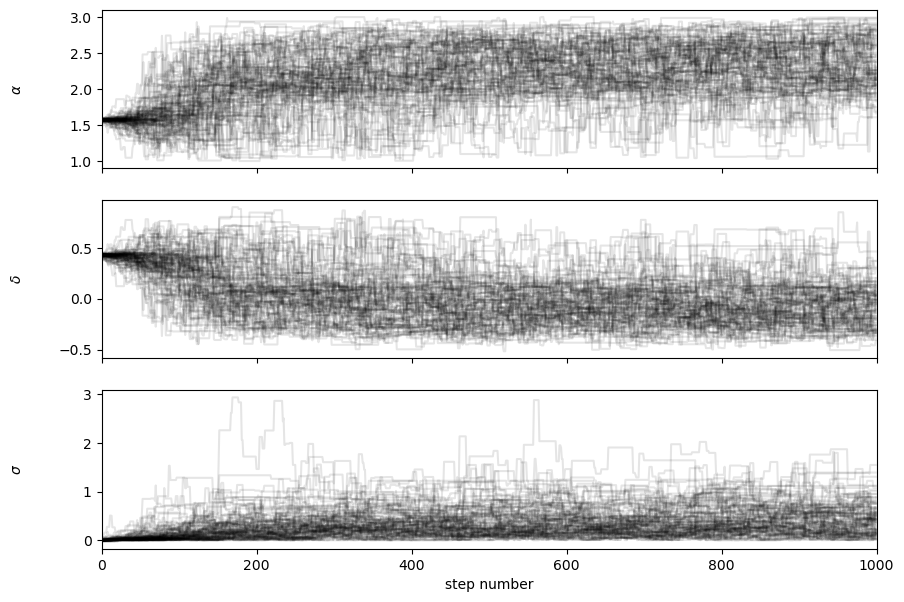

In [47]:
make_chain_plot(sampler)

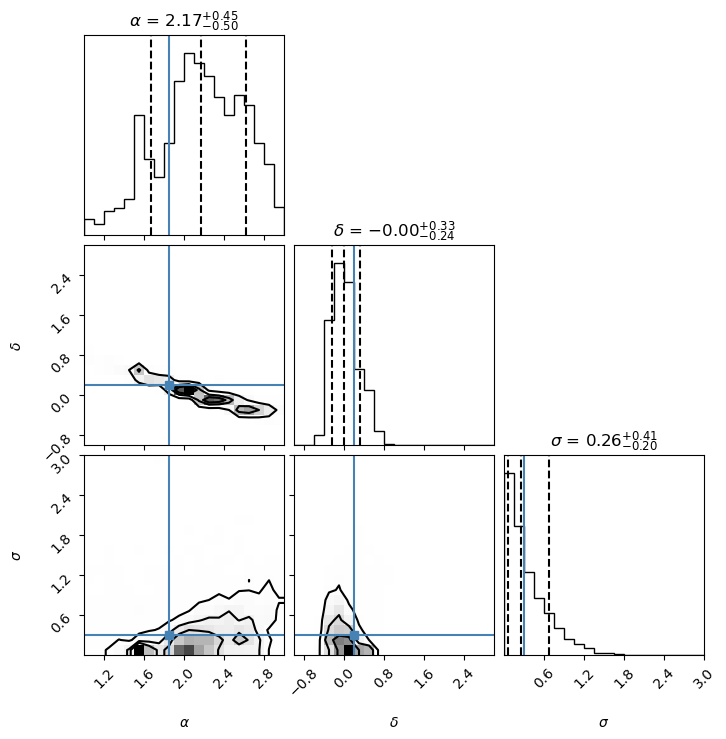

In [48]:
make_corner_plot(sampler)